In [1]:
import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from RFSoC_Daq import RFSoC_Daq
from Biquad import Biquad
from SimBiquad import SimBiquad
from Biquad_Daq import Biquad_Daq
from Waveforms.Waveform import Waveform

In [2]:
daq = Biquad_Daq()

DEBUG:RFSoC_Daq:Asked to load overlay at /home/xilinx/python/zcumts.py
DEBUG:RFSoC_Daq:Adding directory /home/xilinx/python to module search path
DEBUG:RFSoC_Daq:Changing directory to /home/xilinx/python
DEBUG:RFSoC_Daq:Going to try to import zcumts
DEBUG:RFSoC_Daq:Found Overlay class Overlay from module pynq.overlay
DEBUG:RFSoC_Daq:Found RFSoC overlay zcuMTS


Turning on SYNC
Turning off SYNC


DEBUG:RFSoC_Daq:Created RFSoC device
DEBUG:RFSoC_Daq:Restoring original module search path
DEBUG:RFSoC_Daq:Going back to original directory /home/xilinx/rfsoc-rework/Biquad/Notebooks2


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [4]:
def capture_extended(loop=6):
    filttered_arr = np.array([])
    unfilterred_arr = np.array([])
    for i in range(loop):
        daq.update_waveforms()
        unfilterred_arr = np.concatenate((unfilterred_arr, daq.waveforms[0].waveform))
        filttered_arr = np.concatenate((filttered_arr, daq.waveforms[2].waveform))
        
    return Waveform(filttered_arr), Waveform(unfilterred_arr)

In [5]:
def capture_loop(iterations, loop=6):
    S21_arr = []
    group_delay_arr = []

    N = 512*loop
    T = 3.E9
    dt = 1/T
    
    xf = np.linspace(0.0, 1.0 / (2 * dt), N // 2)
    
    for i in range (iterations):
        filterred, raw = capture_extended(loop)
        
        S21 = filterred.fft/raw.fft
        
        ##Group Delay
        # phase_response = np.angle(filterred.fft_result)
        # unwrapped_phase = np.unwrap(phase_response)
        # delta_f = T / N
        # group_delay = -np.gradient(unwrapped_phase, delta_f)
              
        S21_arr.append(S21)
        # group_delay_arr.append(group_delay[:N//2])
        
    S21_mean = [sum(x) / len(S21_arr) for x in zip(*S21_arr)]
    # group_delay_mean = [sum(x) / len(group_delay_arr) for x in zip(*group_delay_arr)]
    S21_log_mag = 20 * np.log10(np.abs(S21_mean[:N//2]))
    
    return xf, S21_log_mag#, group_delay_mean

In [6]:
def update_coef(A, B, P, Theta):
    
    daq.update_params(A, B, P, theta)
    
    daq.run_Biquad()

In [7]:
##The widget won't load on my home pc so Here's to hard coding
A = 0.8028107634961998
B = -0.9163499900207577
P = 0.7782168894289043
theta = 0.2996203532999784 * np.pi
update_coef(A, B, P, theta)

Execution time: 278.06836128234863 seconds
-11.280990343996248
-12.488915642126136
Filter Frequency : 458.515284MHz | Magnitude -38.08638846769018


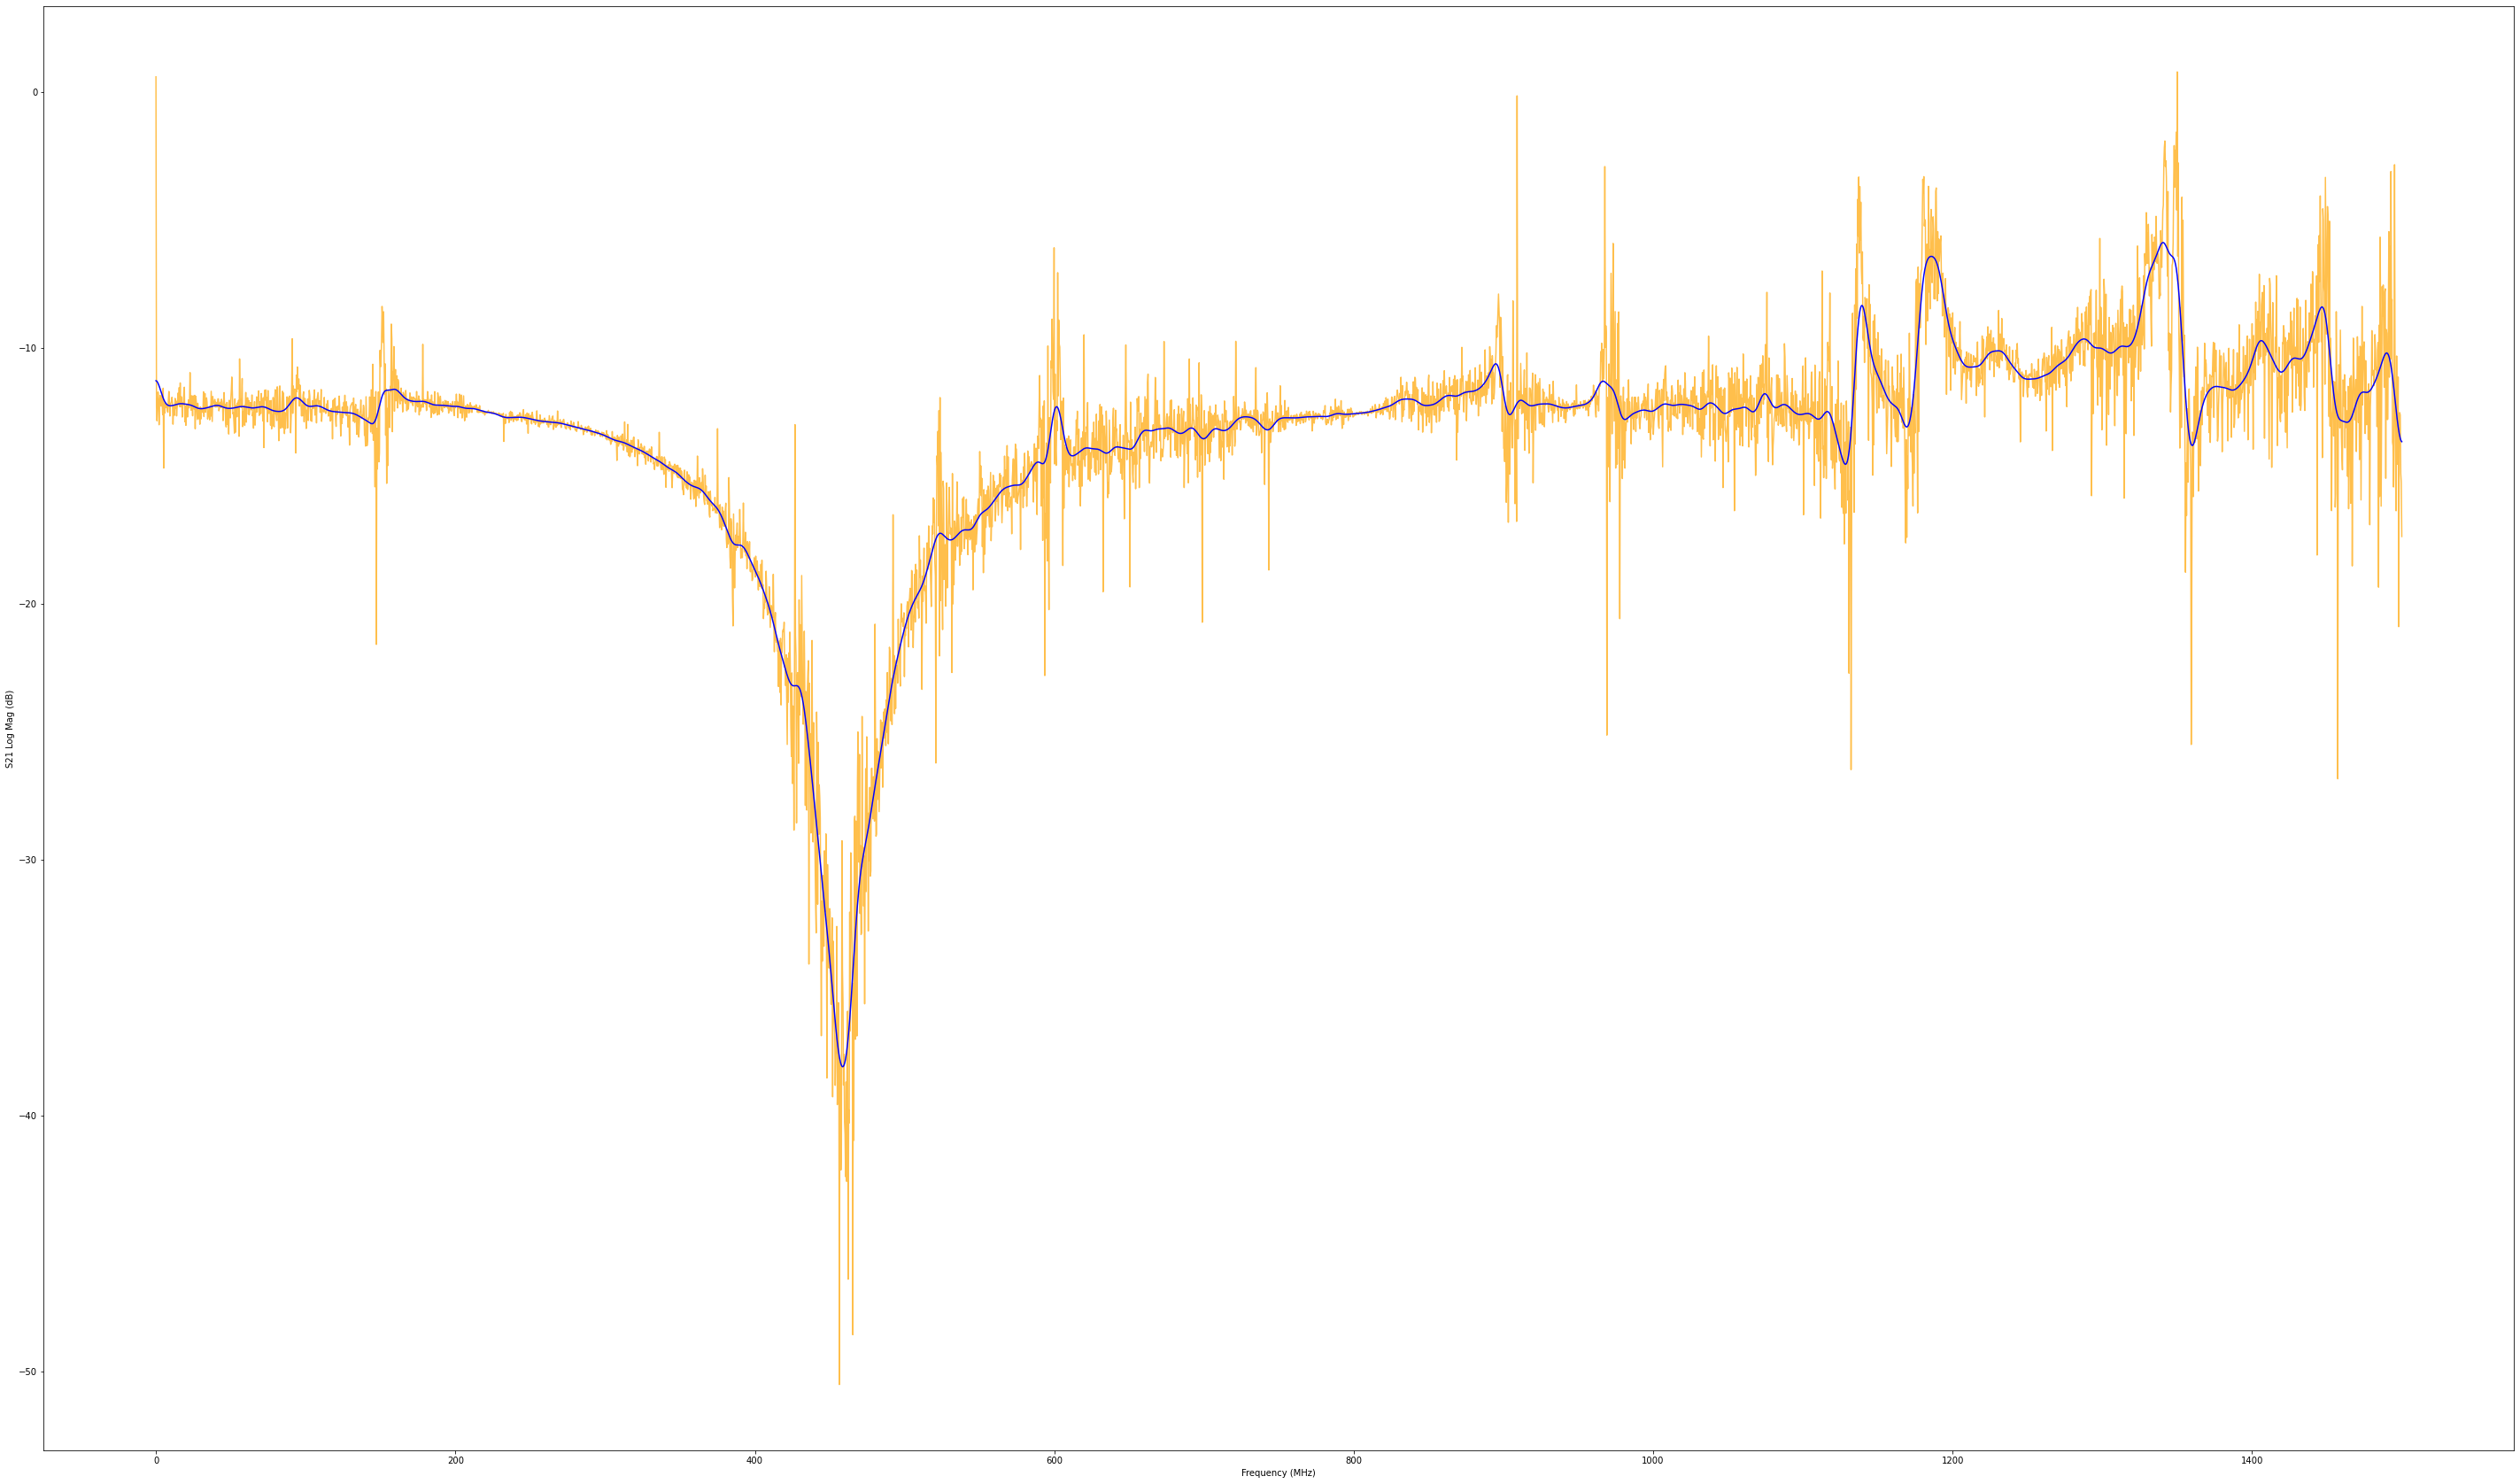

In [10]:
fig, axS21 = plt.subplots(1, 1, figsize=(50, 30))

xf, S21_log_mag= capture_loop(10000,17)

axS21.plot(xf/10**6, S21_log_mag, label='Raw Specturm', color='orange', alpha=0.7)
axS21.set_xlabel("Frequency (MHz)")
axS21.set_ylabel("S21 Log Mag (dB)")

sigma = 10
y_smoothed_gauss = gaussian_filter1d(S21_log_mag, sigma=sigma)
axS21.plot(xf/10**6, y_smoothed_gauss, label='Smoothed (Gaussian)', color='blue')

# axGD.plot(xf/10**6, group_delay_mean, color='orange', alpha=0.7)
# axGD.set_xlabel("Frequency (MHz)")
# axGD.set_ylabel("Group Delay (nanoseconds)")

# sigma = 10
# y_smoothed_gauss = gaussian_filter1d(group_delay_mean, sigma=sigma)
# axGD.plot(xf/10**6, y_smoothed_gauss, label='Smoothed (Gaussian)', color='blue')

print(y_smoothed_gauss[0])
print(np.mean(y_smoothed_gauss[-20:-1]))
print(f'Filter Frequency : {xf[np.argmin(y_smoothed_gauss)]/10**6:3f}MHz | Magnitude {min(y_smoothed_gauss)}')

plt.show()